# Latent GP with Negative Binomial likelihood

## Goal
Given a series of counts (admissions, census, etc.) $$y(t) \text{ for } t = 1, ..., T$$ where $t$ is an integer representing a date in time. Assuming $t = T$ is today, want to predict counts $$y(T+1), y(T+2), ..., y(T+7)$$ for the week ahead.

## Model

We will suppose that $y$ is Negative Binomial distributed over the exponential of a latent Gaussian Process, i.e.,
$$y(t) \sim \text{NegativeBinomial}(\mu = \text{exp}(f(t)), \alpha)$$

where $f$ is modeled by a Gaussian Process
$$ f(t) \sim N(\mu(t), \sigma(t,t'))$$
with constant mean
$$\mu(t) = c$$
and squared exponential covariance
$$\sigma(t,t') = a^2 \exp\left(-\frac{(t-t')^2}{2l^2}\right)$$

## Hyperparameters

| Parameter | Prior: TruncatedNormal(low=0) |
|---------- | -------------------------------------------- |
| $c$ - mean | $\mu=7, \sigma=10$ |
| $a$ - amplitude | $\mu=10, \sigma=10$ |
| $l$ - time-scale | $\mu=10, \sigma=10$ |
| $\alpha$ - dispersion | $\mu=500, \sigma=500$ |

In [140]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
import theano.tensor as tt
import logging
logger = logging.getLogger('arviz')
logger.setLevel(logging.ERROR)

In [141]:
train_df = pd.read_csv('../Middlesex.csv')
y = train_df['cases'].values
T = len(y)
t = np.arange(T)[:,None]

In [142]:
with pm.Model() as model:
    c = pm.TruncatedNormal('mean', mu=7, sigma=10, lower=0)
    mean_func = pm.gp.mean.Constant(c=c)
    
    a = pm.TruncatedNormal('amplitude', mu=10, sigma=10, lower=0)
    l = pm.TruncatedNormal('time-scale', mu=10, sigma=10, lower=0)
    cov_func = a**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l)
    
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)
    
    f = gp.prior('f', X=t)
    
    alpha = pm.TruncatedNormal('alpha', mu=500, sigma=500, lower=0)
    y_ = pm.NegativeBinomial('y', mu=tt.exp(f)+1e-6, alpha=alpha, observed=y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/allylee/miniconda3/envs/spr_2020s_env/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, f_rotated_, time-scale, amplitude, mean]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [08:39<00:00,  2.89it/s]
The acceptance probability does not match the target. It is 0.955709007949093, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence chec

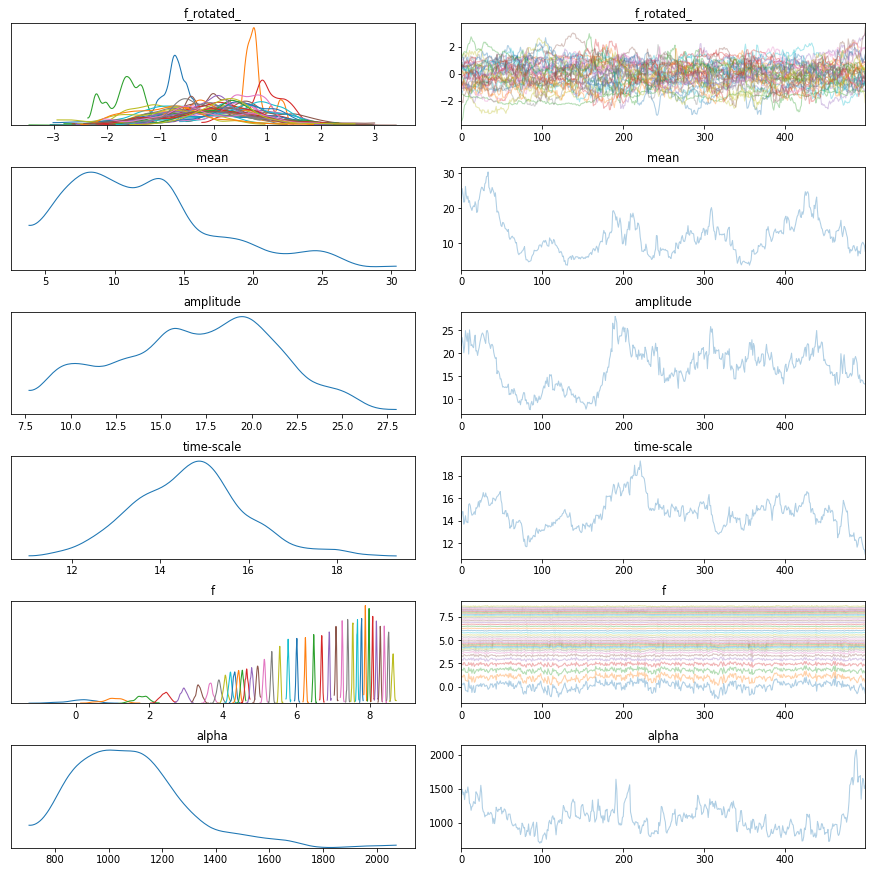

In [143]:
with model:
    trace = pm.sample(500, chains=1, tune=1000, target_accept=.99)

pm.traceplot(trace);

In [144]:
post_mean = pm.summary(trace)['mean'].to_dict()
for key in ['mean', 'amplitude', 'time-scale', 'alpha']:
    print(key, post_mean[key])

mean 12.257
amplitude 16.889
time-scale 14.699
alpha 1081.319


In [145]:
print('Per day log likelihood:')
print(y_.logp(trace[-1]) / T)

Per day log likelihood:
-4.281622396067029


In [146]:
X_new = np.arange(T+7)[:,None]

with model:
    f_pred = gp.conditional('f_pred', X_new)
    y_pred = pm.NegativeBinomial('y_pred', mu=tt.exp(f_pred)+1e-6, alpha=alpha, shape=(len(X_new),))

In [147]:
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[y_pred], samples=1000)

100%|██████████| 1000/1000 [00:03<00:00, 271.74it/s]


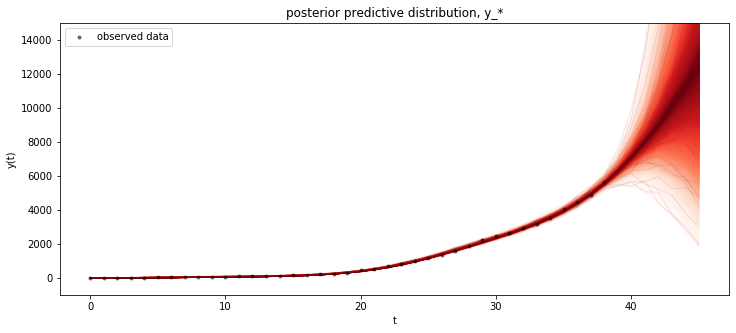

In [148]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca();
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples['y_pred'], X_new, plot_samples=True);
plt.plot(t, y, 'ok', ms=3, alpha=0.5, label="observed data");
plt.xlabel('t'); plt.ylabel('y(t)');
plt.ylim([-1000, 15000]);
plt.title('posterior predictive distribution, y_*'); plt.legend();

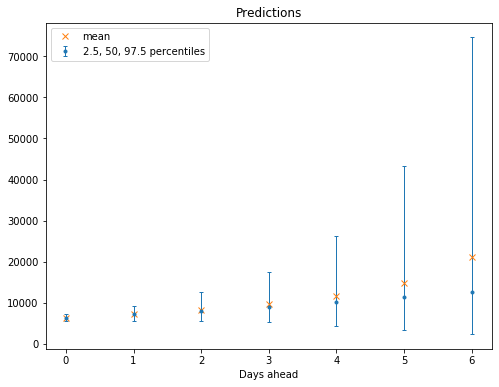

In [150]:
low = np.zeros(7)
high = np.zeros(7)
mean = np.zeros(7)
median = np.zeros(7)

for i in range(-7, 0):
    low[i] = np.percentile(pred_samples['y_pred'][:,i], 2.5)
    high[i] = np.percentile(pred_samples['y_pred'][:,i], 97.5)
    median[i] = np.percentile(pred_samples['y_pred'][:,i], 50)
    mean[i] = np.mean(pred_samples['y_pred'][:,i])

plt.figure(figsize=(8,6))
plt.errorbar(np.arange(7), median,
             yerr=[median-low, high-median],
             capsize=2, fmt='.', linewidth=1,
             label='2.5, 50, 97.5 percentiles')
plt.plot(np.arange(7), mean, 'x', label='mean')
plt.title('Predictions')
plt.xlabel('Days ahead')
plt.legend()
plt.show()